# Problem 8.5 from Network Science book by Barabasi
---
Generate a random network with the Erdős-Rényi $G(N,p)$ model and a <br>
scale-free network with the configuration model, with $N = 10^3$ nodes and<br>
average degree 〈k〉 = 2. Assume that on each node there is a bucket which<br>
can hold as many sand grains as the node degree. Simulate then the fol-<br>
lowing process:<br><br>
**(a)** At each time step add a grain to a randomly chosen node i.<br> <br>
**(b)** If the number of grains at node i reaches or exceeds its bucket<br>
size, then it becomes unstable and all the grains at the node top<br>
ple to the buckets of its adjacent nodes.<br> <br>
**(c)** If this toppling causes any of the adjacent nodes' buckets to be<br>
unstable, subsequent topplings follow on those nodes, until there<br>
is no unstable bucket left. We call this sequence of toppings an<br>
avalanche, its size s being equal to the number of nodes that<br>
turned unstable following an initial perturbation (adding one<br>
grain).<br> <br>
Repeat (a)-(c) $10^4$ times. Assume that at each time step a fraction $10^{–4}$<br>
of sand grains is lost in the transfer, so that the network buckets do not<br>
become saturated with sand. Study the avalanche distribution P(s).

In [13]:
#initializations
using Graphs
using Plots
using Colors
using Statistics
using StatsBase

We create graph generators using the ER-G(n,p) and scalefree-configuration models from scratch but use the Graphs.jl library as a base.

In [4]:
#Erdos-Renyi G(N,p) model.
function Erdos_Renyi_Generator(N, lambda)
    probability = lambda / (N - 1)
    graph = SimpleGraph(N)
    for i in 1:N-1
        for j in i:N
            if rand() <= probability
                add_edge!(graph, i, j)
            end
        end
    end
    return graph
end
#Configuration Model (for <k> = 2, choose gamma = 2.09)
function Configuration_Generator(N, gamma)
    degree_Array = Int[]
    Each_degree_count = []
    for i in 1:N-1
        push!(Each_degree_count, (i)^(-gamma))
    end
    normalizer = N / sum(Each_degree_count) 
    Each_degree_count = floor.(Int, Each_degree_count .* normalizer)
    Each_degree_count[1] = Each_degree_count[1] + (N - sum(Each_degree_count))
    for i in 1:N-1
        counter = Each_degree_count[i]
        if counter != 0
            for j in 1:counter
                push!(degree_Array, i)
            end
        end
    end
    graph = random_configuration_model(N, degree_Array)
    return graph
end
mean(degree(Configuration_Generator(1000, 2.09)))

2.01

We create an array to hold the number of grains of sand in each node. We also create an array of the degrees of each node to finc the maximum capacity of each node.


In [ ]:
#Initialization Parameters
N = 1000
gamma = 2.09
lambda = 2
SF_Graph = Configuration_Generator(N, gamma)
ER_Graph = Erdos_Renyi_Generator(N, lambda)
SF_Degree_Array = degree(SF_Graph)
ER_Degree_Array = degree(ER_Graph)
SF_Neighbors_Array = []
ER_Neighbors_Array = []
for i in 1:N
    push!(SF_Neighbors_Array, neighbors(SF_Graph, i))
    push!(ER_Neighbors_Array, neighbors(ER_Graph, i))
end
SF_Sand = zeros(Int, N)
ER_Sand = zeros(Int, N)

We define a function that adds sand to the nodes after a time-step. It also returns of failure happens.

In [6]:
function sand_Timestep(degree_Array, sand_Array, neighbors_Array)
    N = length(degree_Array)
    random_Node = rand(1:N)
    sand_Array[random_Node] = sand_Array[random_Node] + 1
    if sand_Array[random_Node] > degree_Array[random_Node]
        failure_Bool = true
    else
        failure_Bool = false
    end
    sand_Array = cascading_Failure(degree_Array, sand_Array, neighbors_Array, random_Node)
    if rand() <= 10^(-4)
        random_Node_2 = rand(1:N)
        sand_Array[random_Node] = sand_Array[random_Node] - 1
    end
    return sand_Array, failure_Bool
end

sand_Timestep (generic function with 1 method)

We define the cascading failure function which is a recursive function that checks if each node needs to cascade and does the appropriate calculations. It also counts the number of failures.

In [7]:
function cascading_Failure(degree_Array, sand_Array, neighbors_Array, node_Number)
    if sand_Array[node_Number] > degree_Array[node_Number]
        global failure_Counter = failure_Counter + 1
        for neighbor in neighbors_Array[node_Number]
            sand_Array[neighbor] = sand_Array[neighbor] + 1
        end
        sand_Array[node_Number] = 0
        for neighbor in neighbors_Array[node_Number]
            sand_Array = cascading_Failure(degree_Array, sand_Array, neighbors_Array, neighbor)
        end
    end
    return sand_Array
end

cascading_Failure (generic function with 1 method)

now we write a loop to calculate 10000 timesteps.

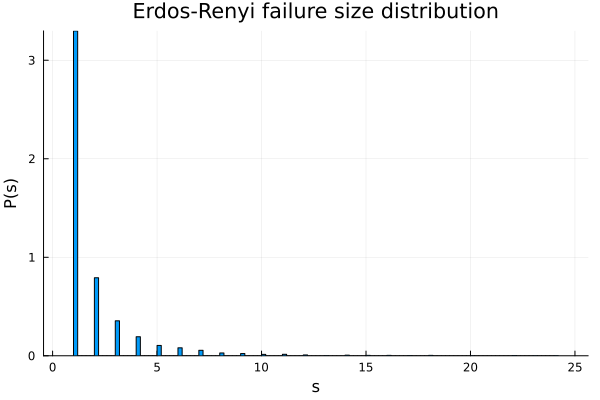

In [24]:
max_Time = 10^4
#For Erdos-Renyi
ER_Sand = zeros(Int, N)
ER_failure_Size = Int[]
for i in 1:max_Time
    failure_Counter = 0
    ER_Sand, failure_Bool = sand_Timestep(ER_Degree_Array, ER_Sand, ER_Neighbors_Array)
    if failure_Bool == true
        push!(ER_failure_Size, failure_Counter)
    end
end
histogram(ER_failure_Size, normalize = :pdf, title = "Erdos-Renyi failure size distribution", legend = false, xlabel = "s", ylabel = "P(s)")

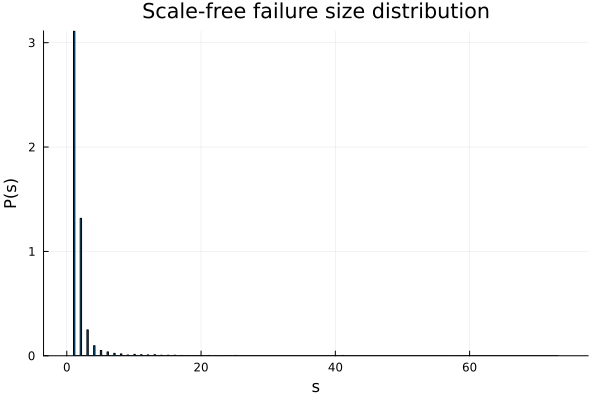

In [25]:
max_Time = 10^4
#For Scale-free Configuration Model
SF_Sand = zeros(Int, N)
SF_failure_Size = Int[]
for i in 1:max_Time
    failure_Counter = 0
    SF_Sand, failure_Bool = sand_Timestep(SF_Degree_Array, SF_Sand, SF_Neighbors_Array)
    if failure_Bool == true
        push!(SF_failure_Size, failure_Counter)
    end
end
histogram(SF_failure_Size, normalize = :pdf, title = "Scale-free failure size distribution", legend = false, xlabel = "s", ylabel = "P(s)")

we write a function that binns the data for more analysis.

In [ ]:
function bin_Vector(vec)
    sorted_Vec = sort(vec)
    sorted_Unique_Vec = sort(unique(sorted_Vec))
    Xaxis = sorted_Unique_Vec
    Yaxis = Int[]
    for i in sorted_Unique_Vec
        quantiy = count(j->(j==i), sorted_Vec)
        push!(Yaxis, quantiy)
    end
    return Xaxis, Yaxis
end

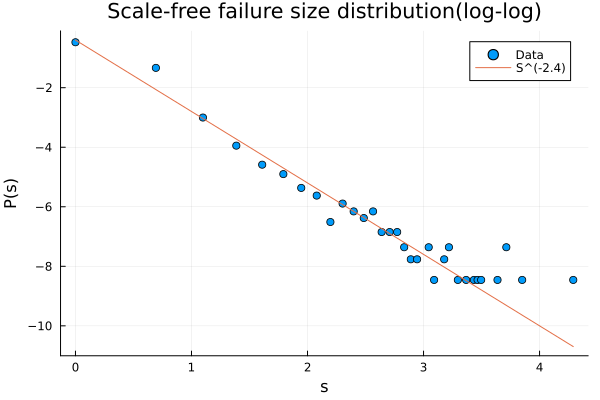

In [49]:
SF_s, SF_Ps = bin_Vector(SF_failure_Size)
SF_Ps = SF_Ps ./ sum(SF_Ps)
SF_s = log.(SF_s)
SF_Ps = log.(SF_Ps)
f1(x) = -0.4 - 2.4 * x
scatter(SF_s, SF_Ps, title = "Scale-free failure size distribution(log-log)", label = "Data", xlabel = "s", ylabel = "P(s)")
plot!(f1, label = "S^(-2.4)")

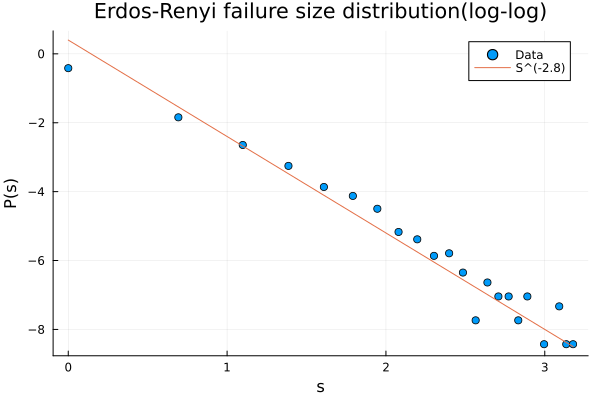

In [61]:
ER_s, ER_Ps = bin_Vector(ER_failure_Size)
ER_Ps = ER_Ps ./ sum(ER_Ps)
ER_s = log.(ER_s)
ER_Ps = log.(ER_Ps)
f2(x) = 0.4 - 2.8 * x
scatter(ER_s, ER_Ps, title = "Erdos-Renyi failure size distribution(log-log)", label = "Data", xlabel = "s", ylabel = "P(s)")
plot!(f2, label = "S^(-2.8)")